# Flower Classification using Vision Transformer

> The data used in this notebook can be found on Kaggle. <br>
> Look for **Flower Classification with TPUs** on Kaggle. <br>

## About

> Using ViT to classify 104 different flower species.

> - In this tutorial we will be building a classifier that distinguishes between 104 different flower species. Note some data preprocessing has been done beforehand to produce the train.csv file you see below.

First we will import all the necessary libraries we need for this tutorial.

In [1]:
#collapse-hide
import os
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from pylab import rcParams

from tqdm.notebook import tqdm

import cv2
import albumentations as A

from apex import amp

import timm

from sklearn import model_selection
from sklearn import metrics

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau, CyclicLR
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler


train_path = './input/jpeg-224x224/train'

print('Number of Classes: ', len(os.listdir(train_path)))

Number of Classes:  104


Our train.csv file contains two columns: id and class. The id column indicates where our images our located and the class column indicates what type of flower it is. For example, a class with 1 indicates that the flower is a **hard-leaved pocket orchid**.

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,class
0,train/hard-leaved pocket orchid/11376.jpeg,1
1,train/hard-leaved pocket orchid/7037.jpeg,1
2,train/hard-leaved pocket orchid/8890.jpeg,1
3,train/hard-leaved pocket orchid/11168.jpeg,1
4,train/hard-leaved pocket orchid/7658.jpeg,1


Here we will create our image dataset to process our images so that we can feed it neatly into our dataloader. 

In [3]:
class FlowerDataset(Dataset):
    def __init__(self, df, labels, transforms=None):
        self.df = df
        self.labels = labels
        self.transforms = transforms
  
    def __len__(self):
        return len(self.df)
  
    def __getitem__(self, index):
        image_id = self.df['id'].values[index]
        image_path = f'./input/jpeg-224x224/{image_id}'
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        labels = self.labels.values[index]

        if self.transforms:
            augmented = self.transforms(image=image)
            image = augmented['image']

        image = image.astype(np.float32)
        image /= 255.0
        image = image.transpose(2, 0, 1)

        return torch.tensor(image), torch.tensor(labels)

For this example, we will apply some simple data augmentation.

In [5]:
transforms_train = A.Compose([                     
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9, 
                         border_mode=cv2.BORDER_REFLECT)
])

transforms_valid = A.Compose([   
     
])

Let's visualize some examples from our dataset.

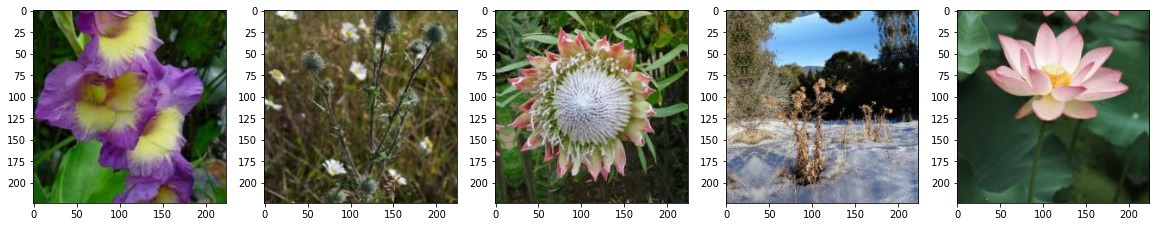

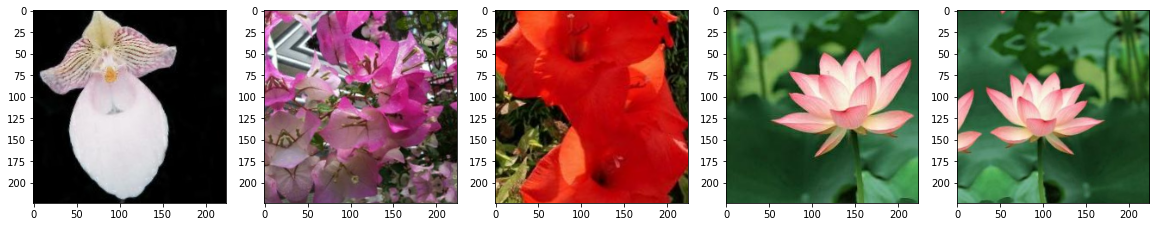

In [6]:
train_ds = FlowerDataset(df[:1000], df[:1000]['class'],transforms=transforms_train)

def show_images(ds):
    rcParams['figure.figsize'] = 20, 10
    for i in range(2):
        f, axarr = plt.subplots(1, 5)
        for p in range(5):
            idx = np.random.randint(0, len(ds))
            img, label = ds[idx]
            axarr[p].imshow(img.transpose(0,1).transpose(1, 2))

show_images(train_ds)

Here we will import a pretrained model from timm which a PyTorch Image Library. 

In [ ]:
model = timm.create_model('vit_base_patch16_224', pretrained=True)

Once we've downloaded the model we'll make some minor adjustments so that we can use it for our own classifier. <br>
Since we are trying to classify 104 different flower species we need to change the out_features of the head of our model to 104. 

In [7]:
class VisionTransformer(nn.Module):
    def __init__(self, model=model):
        super(VisionTransformer, self).__init__()

        self.base_model = model
        self.base_model.head = nn.Linear(768, 104)

    def forward(self, x):

        x = self.base_model(x)

        return x

Here we have our train loop function and valid loop function. <br>
Each function iterates through the dataloader to grab the images and labels. <br>
We then pass the images into our model to make the predictions. <br>
Once we have our predictions we compare the predictions with the labels using our loss function. <br>
We then record our loss function. <br>

In [8]:
def train_fn(model, loader, optimizer, loss_fn, device):
    model.train()

    avg_train_loss = 0.0
    train_accuracy = 0.0

    preds = []
    labels = []

    for step, (data, targets) in enumerate(loader):
        data = data.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.long)

        optimizer.zero_grad()

        outputs = model(data)
        loss = loss_fn(outputs, targets)
        avg_train_loss += loss.item() / len(loader)

        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()

        if ((step + 1) % 1 == 0) or ((step + 1) == len(loader)):
            optimizer.step()

        preds.append(outputs.argmax(1).detach().cpu().numpy())
        labels.append(targets.detach().cpu().numpy())

    preds = np.concatenate(preds)
    labels = np.concatenate(labels)

    train_accuracy = metrics.accuracy_score(preds, labels)

    return avg_train_loss, train_accuracy

def valid_fn(model, loader, loss_fn, device):
    model.eval()

    avg_val_loss = 0.0
    val_accuracy = 0.0

    preds = []
    labels = []

    with torch.no_grad():
        for step, (data, targets) in enumerate(loader):
            data = data.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.long)

            outputs = model(data)
            loss = loss_fn(outputs, targets)

            avg_val_loss += loss.item() / len(loader)

            preds.append(outputs.argmax(1).detach().cpu().numpy())
            labels.append(targets.detach().cpu().numpy())

        preds = np.concatenate(preds)
        labels = np.concatenate(labels)

        val_accuracy = metrics.accuracy_score(preds, labels)

    return avg_val_loss, val_accuracy

For this example, we'll be using StratifiedKFold for our cross validation scheme.

In [9]:
skf = model_selection.StratifiedKFold(4, shuffle=True, random_state=42)
folds = df.copy()
folds['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(folds, folds['class'])):
    folds.loc[valid_idx, 'fold'] = i
folds.head()

,id,class,fold
0,train/hard-leaved pocket orchid/11376.jpeg,1,1
1,train/hard-leaved pocket orchid/7037.jpeg,1,2
2,train/hard-leaved pocket orchid/8890.jpeg,1,0
3,train/hard-leaved pocket orchid/11168.jpeg,1,3
4,train/hard-leaved pocket orchid/7658.jpeg,1,1


Here we'll run our model using only 1 fold. <br>
Depending on the fold we'll be able to split our model so that we have a training set and a validation set. <br>
Once we have our training set and our validation set we'll feed that into our image dataset and then our dataloader. <br>
Next, well tell our model the following:
- the number of epochs we want to run
- what model we want to use
- which optimizer want to use
- which scheduler we want to use
- and our loss function

After this is all done we can now finally run our model.

In [10]:
for fold in range(1):

    N_FOLDS = 1
    print(f"Fold: {fold+1} / {N_FOLDS}")

    train_idx = np.where((folds['fold'] != fold))[0]
    valid_idx = np.where((folds['fold'] == fold))[0]

    df_this  = folds.loc[train_idx]
    df_valid = folds.loc[valid_idx]

    train_ds = FlowerDataset(df_this, df_this['class'], transforms_train)
    valid_ds = FlowerDataset(df_valid, df_valid['class'],transforms_valid)

    train_loader = torch.utils.data.DataLoader(
      train_ds,
      batch_size=64,
      shuffle=True,
      num_workers=4,
      drop_last=True
    )

    valid_loader = torch.utils.data.DataLoader(
      valid_ds,
      batch_size=64,
      shuffle=False,
      num_workers=4,
      drop_last=False
    )

    NUM_EPOCHS = 10

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = VisionTransformer().to(device)
    optimizer = optim.Adam(model.parameters(), lr=3e-4)
    model, optimizer = amp.initialize(model, optimizer, opt_level="O1")
    scheduler = CosineAnnealingLR(optimizer, NUM_EPOCHS)
    loss_fn = nn.CrossEntropyLoss()

    loss_history = {
      "train": [],
      "valid": []
    }

    acc_history = {
      "train": [],
      "valid": []
    }

    for epoch in range(NUM_EPOCHS):

        running_train_loss, train_accuracy = train_fn(model=model,
                                                      loader=train_loader, 
                                                      optimizer=optimizer, 
                                                      loss_fn=loss_fn,
                                                      device=device)

        scheduler.step(epoch-1)

        loss_history['train'].append(running_train_loss)
        acc_history['train'].append(train_accuracy)


        running_val_loss, val_accuracy = valid_fn(model=model,
                                                  loader=valid_loader, 
                                                  loss_fn=loss_fn, 
                                                  device=device)


        loss_history['valid'].append(running_val_loss)
        acc_history['valid'].append(val_accuracy)

        print(f"Epoch: {epoch+1} | lr: {optimizer.param_groups[0]['lr']:.7f} | train loss: {running_train_loss:.2f} | valid loss: {running_val_loss:.2f} | train accuracy: {train_accuracy:.2f} | valid accuracy: {val_accuracy:.2f}")

Fold: 1 / 1
Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Epoch: 1 | lr: 0.0002927 | train loss: 0.92 | valid loss: 0.38 | train accuracy: 0.81 | valid accuracy: 0.91
Epoch: 2 | lr: 0.0003000 | train loss: 0.28 | valid loss: 0.35 | train accuracy: 0.93 | valid accuracy: 0.91
Epoch: 3 | lr: 0.0002927 | train loss: 0.21 | valid loss: 0.34 | train accuracy: 0.

Let's plot our loss and metric function.

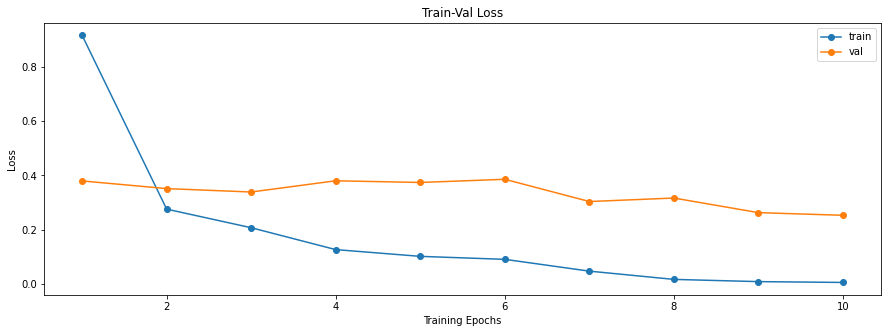

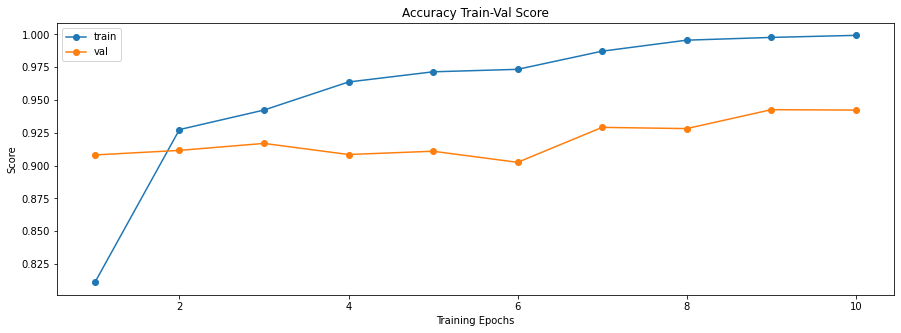

In [11]:
rcParams['figure.figsize'] = 15, 5

plt.title("Train-Val Loss")
plt.plot(range(1,NUM_EPOCHS+1),loss_history["train"],'-o',label="train")
plt.plot(range(1,NUM_EPOCHS+1),loss_history["valid"],'-o',label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

plt.title("Accuracy Train-Val Score")
plt.plot(range(1,NUM_EPOCHS+1),acc_history["train"],'-o',label="train")
plt.plot(range(1,NUM_EPOCHS+1),acc_history["valid"],'-o',label="val")
plt.ylabel("Score")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()